In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

In [2]:
df = pd.read_csv('BTC_TWEETS_PROCESSED.csv')

In [3]:
df.head()

,Unnamed: 0,Text,likeCount,retweetCount,Date,compound,pos,neg,neu,Twitter_Flair,Twitter_TB_Polarity,Twitter_TB_Subjectivity
0,0,@doejohn73 @Diegoqs80 El Bitcoin serÃ¡ manipul...,3,0,2022-01-01 23:59:58+00:00,0.0,0.0,0.0,1.000,-0.972432,0.000000,0.000000
1,1,If your interested in losing money in 2022 kee...,7,2,2022-01-01 23:59:35+00:00,0.8,0.2,0.1,0.667,-0.999887,0.356667,0.703333
2,2,@SirPantsALot2 @fairguinevere @totallynotem_ @...,129,0,2022-01-01 23:59:26+00:00,0.0,0.0,0.0,1.000,0.752120,-0.150000,0.400000
3,3,BTC diamond reversal and expected volatility f...,1,0,2022-01-01 23:59:10+00:00,0.3,0.2,0.0,0.833,-0.894867,-0.100000,0.400000
4,4,if we ever get to the point where we start pay...,1,0,2022-01-01 23:59:10+00:00,0.0,0.0,0.0,1.000,-0.729622,0.000000,0.000000


In [4]:
df1 = pd.read_excel('BTC_CRYPTO.xlsx')

In [5]:
df['date'] = pd.to_datetime(df['Date'])
df['date'] = df['date'].dt.strftime('%y-%m-%d-%H')
df1['date'] = df1['date'].dt.strftime('%y-%m-%d-%H')

In [6]:
#merge = [df,df1]
#merge = pd.concat(merge)
merge = pd.merge(df,df1,on='date')
merge.set_index('date',inplace=True)
merge.sort_values(by='date',inplace=True)

In [7]:
merge.dtypes

Unnamed: 0                   int64
Text                        object
likeCount                    int64
retweetCount                 int64
Date                        object
compound                   float64
pos                        float64
neg                        float64
neu                        float64
Twitter_Flair              float64
Twitter_TB_Polarity        float64
Twitter_TB_Subjectivity    float64
unix                         int64
symbol                      object
open                       float64
high                       float64
low                        float64
close                      float64
Volume BTC                 float64
Volume USDT                float64
tradecount                   int64
dtype: object

In [8]:
merge.drop('Unnamed: 0',axis=1,inplace=True)
merge.drop('unix',axis=1,inplace=True)
merge.drop('symbol',axis=1,inplace=True)
merge.drop('Text',axis=1,inplace=True)
merge.drop('Date',axis=1,inplace=True)
#df.drop('Text',axis=1,inplace=True)

In [9]:
dataset = merge.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = len(merge.columns)
print('Number of features', num_of_features)

Number of features 16


In [11]:
expr_name = 'expr_5'
look_back = 24*7 
#lstm_layers = 50
epochs=5
batch_size=128

In [12]:
train_size_percent = 0.70
pred_col = merge.columns.get_loc('close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, pred_col])
    return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  444414
Testing dataset length  190464
look_back  168


In [13]:

model = Sequential()
model.add(LSTM(32,input_shape=(look_back,num_of_features)))
#model.add(LSTM(100,activation='relu',return_sequences=True))
#model.add(LSTM(50,activation='relu',return_sequences=True))
#model.add(LSTM(25,activation='relu'))
#model.add(LSTM(20,activation='relu'))
#model.add(LSTM(10,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.20, epochs=epochs, batch_size=batch_size,shuffle=False)


Epoch 1/5
2777/2777 [==============================] - 676s 241ms/step - loss: 0.0017 - val_loss: 0.0088
Epoch 2/5
2777/2777 [==============================] - 639s 230ms/step - loss: 3.0500e-04 - val_loss: 0.0119
Epoch 3/5
2777/2777 [==============================] - 619s 223ms/step - loss: 3.5003e-04 - val_loss: 0.0134
Epoch 4/5
2777/2777 [==============================] - 687s 247ms/step - loss: 4.0234e-04 - val_loss: 0.0138
Epoch 5/5
2777/2777 [==============================] - 719s 259ms/step - loss: 4.3913e-04 - val_loss: 0.0134


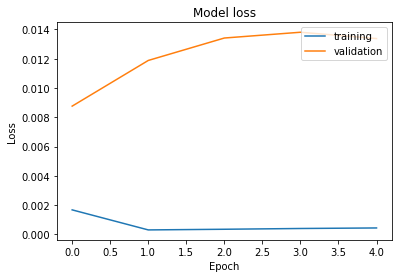

In [14]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training','validation'], loc='upper right')
plt.show()

In [15]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

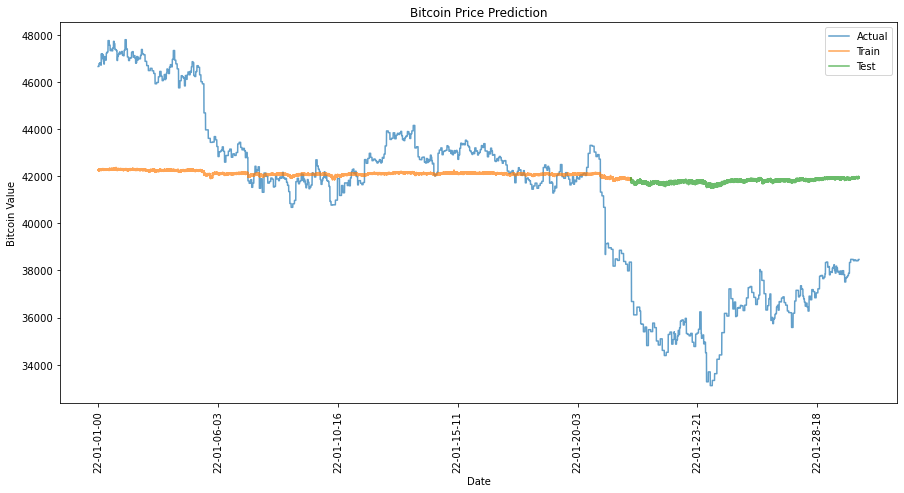

In [16]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(merge.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=True)
time_df2.set_index('date',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [18]:
print('-' * 100)
print('Experiment name:', expr_name)

print('-' * 100)
print('look_back days:', look_back/24)
#print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(merge.columns))


print('-' * 100)
print('Train Score: RMSE: ',(trainScore_RMSE))
print('Test Score: RMSE: ',(testScore_RMSE))

print('-' * 100)
print('Train Score: MAE: ',(trainScore_MAE))
print('Test Score: MAE: ',(testScore_MAE))
print('-' * 100)
print('Model summary:')
model.summary()

----------------------------------------------------------------------------------------------------
Experiment name: expr_5
----------------------------------------------------------------------------------------------------
look_back days: 7.0
epochs: 5
batch_size: 128
dataset features ['likeCount', 'retweetCount', 'compound', 'pos', 'neg', 'neu', 'Twitter_Flair', 'Twitter_TB_Polarity', 'Twitter_TB_Subjectivity', 'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USDT', 'tradecount']
----------------------------------------------------------------------------------------------------
Train Score: RMSE:  2251.24109586841
Test Score: RMSE:  5638.555487982181
----------------------------------------------------------------------------------------------------
Train Score: MAE:  1548.0776539924902
Test Score: MAE:  5516.716085786278
----------------------------------------------------------------------------------------------------
Model summary:
Model: "sequential"
____________________